In [1]:
from __future__ import absolute_import, division, print_function
import pandas as pd
import os
import random
import glob
import tensorflow as tf
import csv
import IPython.display as display

from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
print("TensorFlow version is ", tf.__version__)

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2
import os

TensorFlow version is  1.13.1


# Set up Hyperparameters

In [2]:
RANDOM_STATE = 42
LR = 1e-4
BS = 64
IMG_SIZE = (256, 256)
NUM_CLASSES=20
TEST_SIZE = 0.2

# Used for model training
EPOCHS = 20
N_WORKERS = 8

N_LAYERS_FINE_TUNE = 5

# Load data

In [3]:
classes = ['sea', 
          'snowboard', 
          'skateboard', 
          'bat', 
          'traffic light', 
          'roadside machine', 
          'road', 
          'utensil', 
          'food', 
          'bottle', 
          'toothbrush', 
          'wall-clock',
           'bread',
          'vegetable',
          'banana',
          'toaster',
          'oven',
          'bird',
          'umbrella',
          'bag'
         ]
df = pd.read_csv('train.txt', delimiter='\t', header=None, names=['filename', 'class'])
df.head()



,filename,class
0,0.jpg,"13,18"
1,1.jpg,19
2,2.jpg,10
3,3.jpg,2
4,4.jpg,"8,7"


# Split in to test and train

In [4]:
try:
    df['class'] = df['class'].apply(lambda x:x.split(",")) 
except AttributeError as e:
    print('Already converted to a list')
    print(e)

train_df, test_df = train_test_split(df, test_size=TEST_SIZE)


In [5]:
df.head()

,filename,class
0,0.jpg,"[13, 18]"
1,1.jpg,[19]
2,2.jpg,[10]
3,3.jpg,[2]
4,4.jpg,"[8, 7]"


# Set up Image Generator

In [6]:
# Rescale all images by 1./255 and apply image augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_dataframe(
                train_df,  # Source directory for the training images
                directory='train2014',
                target_size=IMG_SIZE,  
                batch_size=BS,
                color_mode='rgb',
                seed=RANDOM_STATE, 
                #classes = classes,
                shuffle=False,
                class_mode='categorical',
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                horizontal_flip=True,
                vertical_flip=True)

# Flow validation images in batches of 20 using test_datagen generator
test_generator = validation_datagen.flow_from_dataframe(
                test_df, # Source directory for the validation images
                directory='train2014',
                seed=RANDOM_STATE, 
                color_mode='rgb',
                target_size=IMG_SIZE,
                batch_size=BS,
                #classes = classes
                class_mode='categorical',
                shuffle=False
                )

train_filenames = train_generator.filenames
train_labels_kv = (train_generator.class_indices)


test_filenames = test_generator.filenames
test_labels_kv = (test_generator.class_indices)


Found 25540 images belonging to 20 classes.
Found 6385 images belonging to 20 classes.


# Create base model with pre-trained weights
We will create the base model from the InceptionResNetV2 model developed at Google, and pre-trained on the ImageNet dataset, a large dataset of 1.4M images and 1000 classes of web images. This is a powerful model. Let's see what the features that it has learned can do for our cat vs. dog problem.

First, we need to pick which intermediate layer of MobileNet V2 we will use for feature extraction. A common practice is to use the output of the very last layer before the flatten operation, the so-called "bottleneck layer". The reasoning here is that the following fully-connected layers will be too specialized to the task the network was trained on, and thus the features learned by these layers won't be very useful for a new task. The bottleneck features, however, retain much generality.

Let's instantiate an MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, we load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [7]:
IMG_SHAPE = (IMG_SIZE[0],IMG_SIZE[1] , 3)

#base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet')
#base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,include_top=False, weights='imagenet')
base_model = tf.keras.applications.ResNet101v2(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.5/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


# Feature extraction
We will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

Freeze the convolutional base
It's important to freeze the convolutional based before we compile and train the model. By freezing (or setting layer.trainable = False), we prevent the weights in these layers from being updated during training.

In [8]:
base_model.trainable = True
# Fine tune from this layer onwards


# Freeze all the layers before the `fine_tune_at` layer
#for layer in base_model.layers[:N_LAYERS_FINE_TUNE]:
#    layer.trainable =  False

print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


# Add a classification head
Now let's add a few layers on top of the base model:

In [9]:
model = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(20, activation='sigmoid')
])

In [10]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr=LR, decay=LR/EPOCHS),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 20)                40980     
Total params: 23,628,692
Trainable params: 23,575,572
Non-trainable params: 53,120
_________________________________________________________________


In [11]:
len(model.trainable_variables)

214

In [12]:

steps_per_epoch = train_generator.n // BS
test_steps = test_generator.n // BS
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('best_ResNet101v2_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit_generator(train_generator, 
                              steps_per_epoch = steps_per_epoch,
                              epochs=EPOCHS, 
                              workers=N_WORKERS,
                              use_multiprocessing=True,
                              validation_data=test_generator, 
                              validation_steps=test_steps,
                              callbacks=[es, mc]
                             )

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
100/100 [==============================] - 21s 208ms/step - loss: 0.2909 - acc: 0.9231

Epoch 00001: val_loss improved from inf to 0.29091, saving model to best_resnet50_model.h5
400/400 [==============================] - 186s 464ms/step - loss: 0.1393 - acc: 0.9478 - val_loss: 0.2909 - val_acc: 0.9231
Epoch 2/20
100/100 [==============================] - 18s 184ms/step - loss: 0.1464 - acc: 0.9482

Epoch 00002: val_loss improved from 0.29091 to 0.14641, saving model to best_resnet50_model.h5
400/400 [==============================] - 169s 422ms/step - loss: 0.0774 - acc: 0.9715 - val_loss: 0.1464 - val_acc: 0.9482
Epoch 3/20
100/100 [==============================] - 19s 193ms/step - loss: 0.1278 - acc: 0.9583

Epoch 00003: val_loss improved from 0.14641 to 0.12776, saving model to best_resnet50_model.h5
400/400 [==============================] - 169s 422ms/step - loss: 0.0424 - acc: 0.9852 - val_loss: 0.1278 - val_acc: 0.9583

# Save the entire model as HD5 file
Recreate the exact same model, including weights and optimizer.

`new_model = keras.models.load_model('my_model.h5')`

`new_model.summary()`

In [13]:
# Save entire model to a HDF5 file
#model_path = 'InceptionResNetV2_train.h5'
#model_path = 'Resnet50_train.h5'
#model.save(model_path)

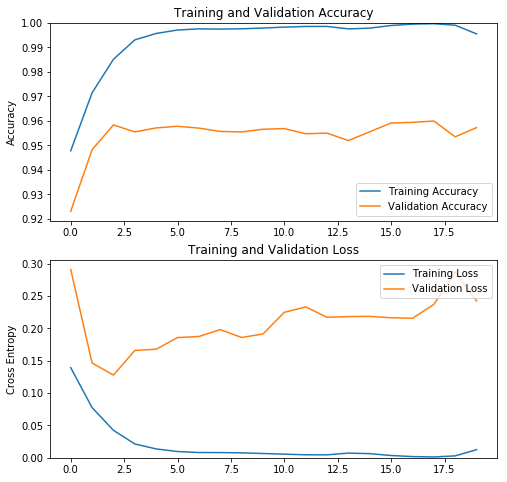

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

# Predictions

In [18]:

# reset validation_generator
new_model = keras.models.load_model('best_resnet50_model.h5')
pred = new_model.predict_generator(generator=test_generator, verbose=1,steps=test_steps)



100/100 [==============================] - 30s 305ms/step


In [19]:


import IPython.display as display


predicted_class_indices=np.argmax(pred,axis=1) # top 1 prediction
labels_vk = dict([(v,k) for k,v in test_labels_kv.items()])
predictions = [labels_vk[k] for k in predicted_class_indices]

results=pd.DataFrame({"Filename":test_filenames,
                      "Predictions":predictions })

results.to_csv("results_vgg16.csv",index=False)

correct_pred = []


count = 0

for image_path, y_pred in zip(test_filenames, predictions):

    actual = df[df["filename"]==os.path.basename(image_path)]
    y_train = actual['class'].tolist()
    if str(y_pred) in y_train[0]:
        #for x in y_train[0]:
        #if int(x) == int(y_pred): 
        correct_pred.append(image_path)

    

In [20]:

acc = (len(correct_pred)/float(len(test_filenames)))  * 100    
print(acc)

70.55599060297573
